# Analyze SARS-CoV-2 Spike Glycoprotein Variants
[Work in progress]

This notebook queries the Knowledge Graph for variants in the SARS-CoV S gene and analyzes mutations that may affect the ACE2 binding to the Spike Glycoprotein as well we mutations at the polybasic cleavage site. In addition, it analyzes the geographic locations of the variants.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

In [3]:
import py2neo
py2neo.__version__

'2020.0.0'

#### Connect to COVID-19-Community Knowledge Graph

In [4]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

## Analysis of missense mutations in the SARS-CoV-2 Spike glycoprotein

![Spike protein](../../docs/Spikeprotein.png)

**a.** ACE2 receptor binding domain of the SARS-CoV-2 spike protein. **b.** Polybasic cleavage site with three predicted O-glycosylation sites.

Reference: Andersen, K.G., Rambaut, A., Lipkin, W.I. et al. The proximal origin of SARS-CoV-2. Nat Med 26, 450–452 (2020). [doi:10.1038/s41591-020-0820-9](https://doi.org/10.1038/s41591-020-0820-9)

### Query KG for the S gene and its gene product

Mutation data below are based on the Wuhan-Hu-1 ([NC_045512](http://identifiers.org/resolve?query=ncbiprotein:NC_045512)) reference sequence.

In [5]:
gene_name = 'S'
genome_accession = 'refseq:NC_045512'

In [6]:
query = """
MATCH (g:Gene{name: $gene_name, genomeAccession: $genome_accession})-[:ENCODES]->(p:Protein) 
RETURN g.id as geneAccession, g.name AS geneName, p.accession AS proteinAccession, p.sequence AS proteinSequence
"""
df = graph.run(query, gene_name=gene_name, genome_accession=genome_accession).to_data_frame()

In [7]:
df.head()

,geneAccession,geneName,proteinAccession,proteinSequence
0,refseq:NC_045512-21563-25384,S,uniprot:P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...


In [8]:
seq = df['proteinSequence'].iloc[0]

In [9]:
# TODO check why this sequence is shorter than the one in the figure above.
print('Sequence of the Spike glycoprotein:', len(seq), 'residues')
print(seq)

Sequence of the Spike glycoprotein: 1273 residues
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQD

### Type of Variants in Spike glycoprotein

List of variant types and consequences:

https://uswest.ensembl.org/info/genome/variation/prediction/classification.html

https://uswest.ensembl.org/info/genome/variation/prediction/predicted_data.html#consequences

In [10]:
host_taxonomy_id = 'taxonomy:9606' # human

In [11]:
query = """
MATCH (g:Gene{name: $gene_name, genomeAccession: $genome_accession})-[:HAS_VARIANT]->(v:Variant)
       <-[:HAS_VARIANT]-(s:Strain)
WHERE s.hostTaxonomyId = $host_taxonomy_id
RETURN DISTINCT(v.variantType), v.variantConsequence, count(s)
ORDER BY v.variantType
"""

In [12]:
df = graph.run(query, gene_name=gene_name, genome_accession=genome_accession, host_taxonomy_id=host_taxonomy_id).to_data_frame()

In [13]:
df.head(20)

,(v.variantType),v.variantConsequence,count(s)
0,Deletion,inframe_deletion,237
1,Deletion,stop_gained,1
2,Deletion,frameshift_variant,22
3,Insertion,inframe_insertion,1
4,Insertion,frameshift_variant,8
5,SNP,missense_variant,83418
6,SNP,synonymous_variant,19502
7,SNP,coding_sequence_variant,2866
8,SNP,stop_gained,23
9,SNP,stop_retained_variant,2


### Frequency of mutation by sequence position
**NOTE, some strains have been deposited in both in GISAID and NCBI under different strain ids. They will be double-counted in the analyses below.**

Receptor-binding domain contact residues and O-linked glycan sites are highlighted in the plot below.

In [14]:
query = """
MATCH (g:Gene{name: $gene_name, genomeAccession: $genome_accession})-[:HAS_VARIANT]->(v:Variant{variantConsequence:'missense_variant'})
       <-[:HAS_VARIANT]-(s:Strain)
WHERE s.hostTaxonomyId = $host_taxonomy_id
RETURN v.proteinPosition AS proteinPosition, v.geneVariant as geneVariant, v.proteinVariant AS proteinVariant, 
       s.name as strain, s.collectionDate AS collectionDate
ORDER by geneVariant
"""

In [15]:
df = graph.run(query, gene_name=gene_name, genome_accession=genome_accession, host_taxonomy_id=host_taxonomy_id).to_data_frame()

In [16]:
df.head()

,proteinPosition,geneVariant,proteinVariant,strain,collectionDate
0,334,S:c.1002aaC>aaA,QHD43416.1:p.334N>K,hCoV-19/England/ALDP-5C3A7F/2020,2020-06-19
1,334,S:c.1002aaC>aaA,QHD43416.1:p.334N>K,hCoV-19/England/ALDP-94FF1E/2020,2020-06-16
2,334,S:c.1002aaC>aaA,QHD43416.1:p.334N>K,hCoV-19/England/MILK-93D3EA/2020,2020-06-21
3,334,S:c.1002aaC>aaA,QHD43416.1:p.334N>K,hCoV-19/England/MILK-93CFE7/2020,2020-06-21
4,336,S:c.1006Tgc>Cgc,QHD43416.1:p.336C>R,hCoV-19/Morocco/moh100/2020,2020-05-05


In [17]:
positions = df['proteinPosition'].values

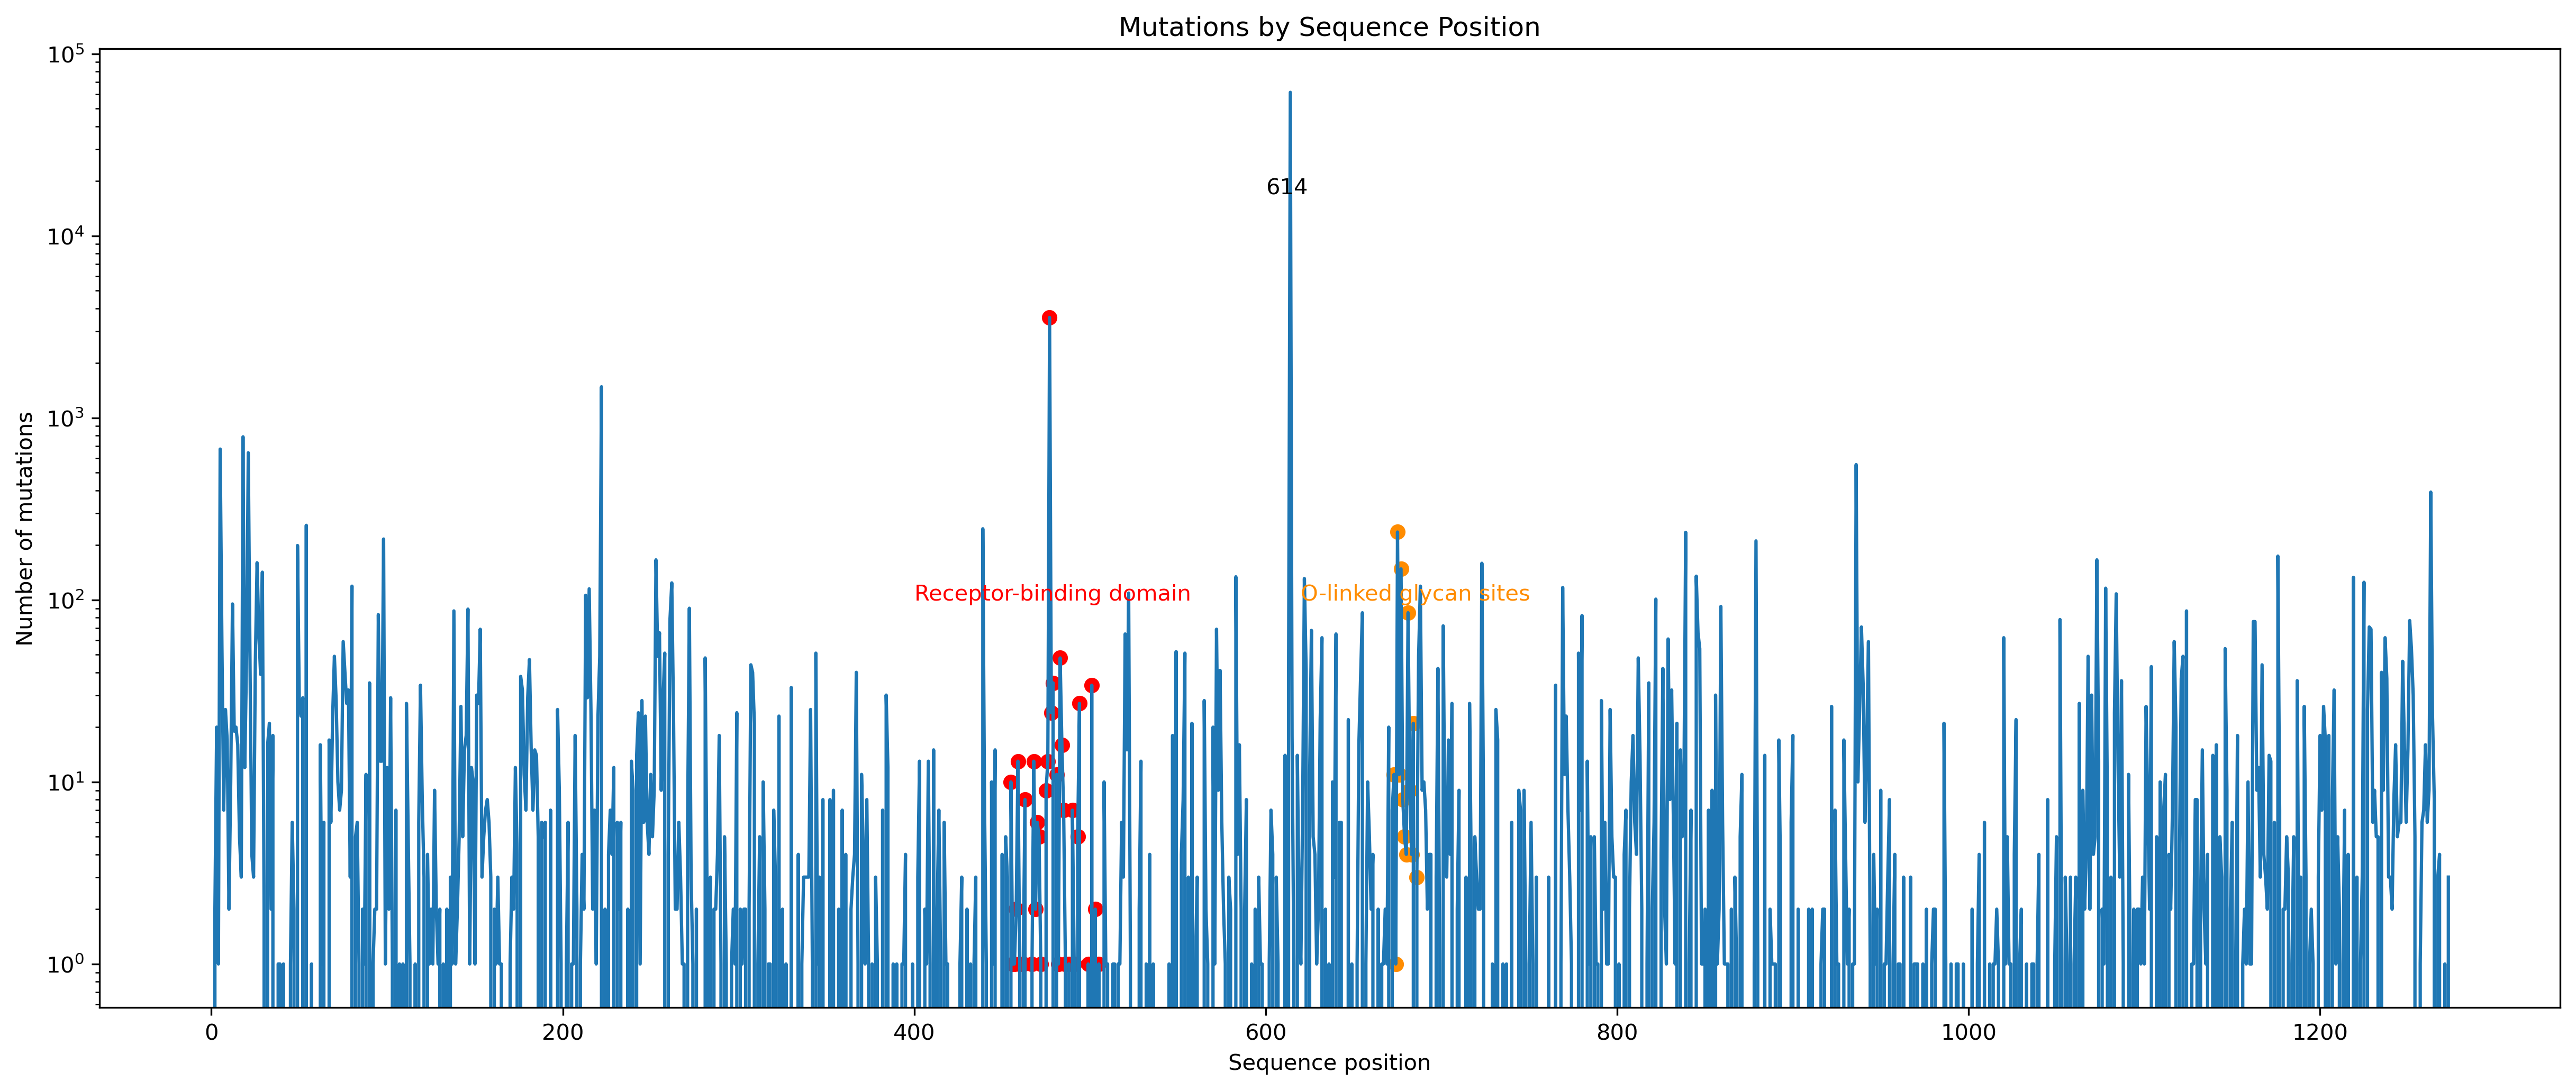

In [18]:
x = np.arange(len(seq)+1)
y = np.zeros(len(seq)+1)
for p in positions:
    y[p] += 1

plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(x, y)
plt.yscale('log')
plt.xlabel('Sequence position')
plt.ylabel('Number of mutations')
plt.title('Mutations by Sequence Position')

# receptor-binding domain (RBD) contact residues in red
rbd = (x >= 455) & (x <= 505)
plt.scatter(x[rbd], y[rbd], color='red') 

# O-linked glycan sites in orange
ogs = (x >= 673) & (x <= 686)
plt.scatter(x[ogs], y[ogs], color='darkorange') 

plt.annotate('614', xy=(600, 17000))
plt.annotate('Receptor-binding domain', xy=(400, 100), color='red')
plt.annotate('O-linked glycan sites', xy=(620, 100), color='darkorange')

plt.show()

##### Mutations at position 614

In [19]:
df.query('proteinPosition == 614').head()

,proteinPosition,geneVariant,proteinVariant,strain,collectionDate
6639,614,S:c.1840Gat>Aat,QHD43416.1:p.614D>N,hCoV-19/Wales/PHWC-160270/2020,2020-04-19
6640,614,S:c.1840Gat>Aat,QHD43416.1:p.614D>N,hCoV-19/England/CAMB-81F82/2020,2020-04-21
6641,614,S:c.1840Gat>Aat,QHD43416.1:p.614D>N,hCoV-19/England/CAMB-81E94/2020,2020-04-22
6642,614,S:c.1841gAt>gCt,QHD43416.1:p.614D>A,hCoV-19/South Korea/KCDC2655/2020,2020-07-21
6643,614,S:c.1841gAt>gCt,QHD43416.1:p.614D>A,hCoV-19/South Korea/KCDC2653/2020,2020-07-13


### Strains with mutations in the Spike glycoprotein receptor-binding domain (RBD)

Six amino acids in the RBD of the spike protein have been shown to be critical for binding to ACE2 receptors: 

L455, F486, Q493, S494, N501, Y505

Python uses zero-based indices, so we subtract 1 to find the position in the sequence.

In [20]:
print(seq[455-1], seq[486-1], seq[493-1], seq[494-1], seq[501-1], seq[505-1])

L F Q S N Y


#### The following variants are missense mutations in the RBD

In [21]:
query = """
MATCH (g:Gene{name: $gene_name, genomeAccession: $genome_accession})-[:HAS_VARIANT]->(v:Variant{variantConsequence:'missense_variant'})
<-[:HAS_VARIANT]-(s:Strain)-[:FOUND_IN]->(l:Location)
WHERE v.proteinPosition IN [455, 486, 493, 494, 501, 505] AND s.hostTaxonomyId = 'taxonomy:9606'
RETURN DISTINCT v.geneVariant as geneVariant, v.proteinVariant AS proteinVariant, 
s.name AS strainName, s.collectionDate AS collectionDate, l.name AS location, 
labels(l) AS locationType, s.id AS strainId
"""
df = graph.run(query, gene_name=gene_name, genome_accession=genome_accession).to_data_frame()

In [22]:
df.head()

,geneVariant,proteinVariant,strainName,collectionDate,location,locationType,strainId
0,S:c.1480Tca>Gca,QHD43416.1:p.494S>A,IHUCOVID-0494,2020-01-01,France,"[Location, Country]",insdc:LR794666
1,S:c.1514tAc>tGc,QHD43416.1:p.505Y>C,hCoV-19/USA/WA-UW-8845/2020,2020-05-08,Washington,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_501157
2,S:c.1481tCa>tTa,QHD43416.1:p.494S>L,SARS-CoV-2/human/AUS/VIC5057/2020,2020-07-19,Victoria,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_519860
3,S:c.1481tCa>tTa,QHD43416.1:p.494S>L,hCoV-19/England/BRIS-12B47B/2020,2020-05-26,England,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_487571
4,S:c.1365ttG>ttT,QHD43416.1:p.455L>F,hCoV-19/Italy/ABR-IZSGC-TE79445/2020,2020-06-13,Abruzzo,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_529007


#### Find variants around these critical residues within a 5 amino acid window (+/- 2 residues)

In [25]:
query = """
MATCH (g:Gene{name: $gene_name, genomeAccession: $genome_accession})-[:HAS_VARIANT]->(v:Variant{variantConsequence:'missense_variant'})
<-[:HAS_VARIANT]-(s:Strain)-[:FOUND_IN]->(l:Location)
WHERE v.proteinPosition IN [453,454,455,456,457, 484,485,486,487,488, 491,492,493,494,495,496,
                            499,500,501,502,503,504,505,506,507] 
      AND s.hostTaxonomyId = $host_taxonomy_id
RETURN DISTINCT v.geneVariant as geneVariant, v.proteinVariant AS proteinVariant, 
s.name AS strainName, s.collectionDate AS collectionDate, s.sex AS sex, s.age as age, 
l.name AS location, l.location AS coordinates, labels(l) AS locationType, s.id AS strainId
"""
df = graph.run(query, gene_name=gene_name, genome_accession=genome_accession, host_taxonomy_id=host_taxonomy_id).to_data_frame()
df.fillna('', inplace=True)
df.head()

,geneVariant,proteinVariant,strainName,collectionDate,sex,age,location,coordinates,locationType,strainId
0,S:c.1462Tgt>Cgt,QHD43416.1:p.488C>R,SARS-CoV-2/human/IRN/COVID19-IRVSH4/2020,2020-05-01,,,Iran,,"[Location, Country]",insdc:MT994632
1,S:c.1451gAa>gGa,QHD43416.1:p.484E>G,hCoV-19/England/20342000104/2020,2020-08-12,,,England,"(-0.70312, 52.16045)","[Location, Admin1]",https://www.gisaid.org/EPI_ISL_528438
2,S:c.1453Ggt>Cgt,QHD43416.1:p.485G>R,SARS-CoV-2/human/AUS/VIC1831/2020,2020-05-29,,,Victoria,"(145.0, -37.0)","[Location, Admin1]",https://www.gisaid.org/EPI_ISL_521879
3,S:c.1453Ggt>Cgt,QHD43416.1:p.485G>R,SARS-CoV-2/human/AUS/VIC1835/2020,2020-05-28,,,Victoria,"(145.0, -37.0)","[Location, Admin1]",https://www.gisaid.org/EPI_ISL_521881
4,S:c.1453Ggt>Cgt,QHD43416.1:p.485G>R,SARS-CoV-2/human/AUS/VIC1829/2020,2020-05-27,male,20,Victoria,"(145.0, -37.0)","[Location, Admin1]",https://www.gisaid.org/EPI_ISL_521878


### Find strains with mutations in the polybasic cleavage site
This site has three predicted O-glycosylation sites:
    
S673, T678, S686

In [26]:
print(seq[673-1], seq[678-1], seq[686-1])

S T S


In [29]:
query = """
MATCH (g:Gene{name: $gene_name, genomeAccession: $genome_accession})-[:HAS_VARIANT]->(v:Variant{variantConsequence:'missense_variant'})
<-[:HAS_VARIANT]-(s:Strain)-[:FOUND_IN]->(l:Location)
WHERE v.proteinPosition IN [673, 678, 686] 
      AND s.hostTaxonomyId = $host_taxonomy_id
RETURN DISTINCT v.geneVariant as geneVariant, v.proteinVariant AS proteinVariant, 
s.name AS strainName, s.collectionDate AS collectionDate, s.sex AS sex, s.age as age, 
l.name AS location, labels(l) AS locationType, s.id AS strainId
"""
df = graph.run(query, gene_name=gene_name, genome_accession=genome_accession, host_taxonomy_id=host_taxonomy_id).to_data_frame()
df.fillna('', inplace=True)
df.head()

,geneVariant,proteinVariant,strainName,collectionDate,sex,age,location,locationType,strainId
0,S:c.2018aGt>aCt,QHD43416.1:p.673S>T,hCoV-19/Switzerland/ZH-ETHZ-280135/2020,2020-09-07,,,Zurich,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_560545
1,S:c.2018aGt>aCt,QHD43416.1:p.673S>T,hCoV-19/England/MILK-9718DC/2020,2020-08-18,,,England,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_553098
2,S:c.2018aGt>aCt,QHD43416.1:p.673S>T,hCoV-19/England/MILK-975085/2020,2020-08-20,,,England,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_552451
3,S:c.2018aGt>aCt,QHD43416.1:p.673S>T,hCoV-19/Wales/MILK-9A8CB2/2020,2020-09-02,,,Wales,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_550037
4,S:c.2018aGt>aCt,QHD43416.1:p.673S>T,250063_865_G10,2020-08-17,,,Bern,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_535589


#### Find variants around these residues within a 5 amino acid window (+/- 2 residues)

In [30]:
query = """
MATCH (g:Gene{name: $gene_name, genomeAccession: $genome_accession})-[:HAS_VARIANT]->(v:Variant{variantConsequence:'missense_variant'})
<-[:HAS_VARIANT]-(s:Strain)-[:FOUND_IN]->(l:Location)
WHERE v.proteinPosition IN [671,672,673,674,675, 676,677,678,679,670, 684,685,686,687,688] 
      AND s.hostTaxonomyId = $host_taxonomy_id
RETURN DISTINCT v.geneVariant as geneVariant, v.proteinVariant AS proteinVariant, 
s.name AS strainName, s.collectionDate AS collectionDate, s.sex AS sex, s.age as age, l.name AS location, 
labels(l) AS locationType, s.id AS strainId
ORDER BY v.proteinVariant, s.collectionDate
"""
df = graph.run(query, gene_name=gene_name, genome_accession=genome_accession, host_taxonomy_id=host_taxonomy_id).to_data_frame()
df.fillna('', inplace=True)
df.head()

,geneVariant,proteinVariant,strainName,collectionDate,sex,age,location,locationType,strainId
0,S:c.2008Ata>Tta,QHD43416.1:p.670I>L,hCoV-19/England/NORW-E8DF8/2020,2020-04-26,,,England,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_453558
1,S:c.2008Ata>Tta,QHD43416.1:p.670I>L,NORW-EB33F,2020-05-03,,,England,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_457419
2,S:c.2008Ata>Tta,QHD43416.1:p.670I>L,NORW-EB28D,2020-05-03,,,England,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_457413
3,S:c.2008Ata>Tta,QHD43416.1:p.670I>L,NORW-EBE4D,2020-05-06,,,United Kingdom,"[Location, Country]",insdc:LR814131
4,S:c.2008Ata>Tta,QHD43416.1:p.670I>L,NORW-EBC07,2020-05-06,,,England,"[Location, Admin1]",https://www.gisaid.org/EPI_ISL_457490


### Mutations in the SARS-CoV-2 "S" gene at different geolocations

In [31]:
query = """
MATCH (g:Gene{name: $gene_name, genomeAccession: $genome_accession})-[:HAS_VARIANT]->(v:Variant{variantConsequence:'missense_variant'})
<-[:HAS_VARIANT]-(s:Strain)-[:FOUND_IN]->(l1:Location)-[:IN*]->(r:USRegion{name:$region})
MATCH (l1)-[:IN]->(l2)
RETURN v.name AS geneVariant, l1.name, l1.location, labels(l1), l2.name, labels(l2), r.name AS region
ORDER BY v.name, l1.name
"""

#### Variants in the US West Region

In [32]:
region = 'West Region'
west = graph.run(query, gene_name=gene_name, genome_accession=genome_accession, region=region).to_data_frame()
west.head()

,geneVariant,l1.name,l1.location,labels(l1),l2.name,labels(l2),region
0,S:c.100Cgt>Tgt,San Diego,"(-117.16472, 32.71571)","[Location, City]",San Diego County,"[Location, Admin2]",West Region
1,S:c.1025tTt>tGt,Los Angeles,"(-118.24368, 34.05223)","[Location, City]",Los Angeles County,"[Location, Admin2]",West Region
2,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region
3,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region
4,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region


#### Variants in the US Northeast Region

In [33]:
region = 'Northeast Region'
northeast = graph.run(query, gene_name=gene_name, genome_accession=genome_accession, region=region).to_data_frame()
northeast.head()

,geneVariant,l1.name,l1.location,labels(l1),l2.name,labels(l2),region
0,S:c.1076aGc>aAc,Queens,"(-73.83652, 40.68149)","[Location, City]",Queens County,"[Location, Admin2]",Northeast Region
1,S:c.1150Cct>Tct,Queens,"(-73.83652, 40.68149)","[Location, City]",Queens County,"[Location, Admin2]",Northeast Region
2,S:c.1150Cct>Tct,Queens,"(-73.83652, 40.68149)","[Location, City]",Queens County,"[Location, Admin2]",Northeast Region
3,S:c.122aAa>aTa,Massachusetts,"(-71.10832, 42.36565)","[Location, Admin1]",United States,"[Location, Country]",Northeast Region
4,S:c.122aAa>aTa,Massachusetts,"(-71.10832, 42.36565)","[Location, Admin1]",New England Division,"[Location, USDivision]",Northeast Region


#### Find variants in common

In [34]:
in_common = pd.merge(west, northeast, on='geneVariant')
in_common[['geneVariant']].drop_duplicates().head(25)

,geneVariant
0,S:c.13Ctt>Ttt
4042,S:c.1501Aat>Tat
4043,S:c.1558Gca>Tca
4056,S:c.1564Gca>Tca
4116,S:c.156caG>caT
4130,S:c.162ttG>ttC
4148,S:c.162ttG>ttT
4208,S:c.1640aCa>aTa
4216,S:c.1709gCt>gTt
4218,S:c.1749gaG>gaT


#### Find unique variants in the West region

In [35]:
in_west_only = pd.merge(west, northeast, on='geneVariant', how='left')
in_west_only.head()

,geneVariant,l1.name_x,l1.location_x,labels(l1)_x,l2.name_x,labels(l2)_x,region_x,l1.name_y,l1.location_y,labels(l1)_y,l2.name_y,labels(l2)_y,region_y
0,S:c.100Cgt>Tgt,San Diego,"(-117.16472, 32.71571)","[Location, City]",San Diego County,"[Location, Admin2]",West Region,NaN,NaN,NaN,NaN,NaN,NaN
1,S:c.1025tTt>tGt,Los Angeles,"(-118.24368, 34.05223)","[Location, City]",Los Angeles County,"[Location, Admin2]",West Region,NaN,NaN,NaN,NaN,NaN,NaN
2,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region,NaN,NaN,NaN,NaN,NaN,NaN
3,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region,NaN,NaN,NaN,NaN,NaN,NaN
4,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
in_west_only.fillna('', inplace=True)
in_west_only.query("`l1.name_y` == ''", inplace=True)
in_west_only = in_west_only[['geneVariant', 'l1.name_x', 'l1.location_x', 'labels(l1)_x', 'l2.name_x', 'labels(l2)_x', 'region_x']]
in_west_only.head(25)

,geneVariant,l1.name_x,l1.location_x,labels(l1)_x,l2.name_x,labels(l2)_x,region_x
0,S:c.100Cgt>Tgt,San Diego,"(-117.16472, 32.71571)","[Location, City]",San Diego County,"[Location, Admin2]",West Region
1,S:c.1025tTt>tGt,Los Angeles,"(-118.24368, 34.05223)","[Location, City]",Los Angeles County,"[Location, Admin2]",West Region
2,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region
3,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region
4,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region
5,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region
6,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region
7,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region
8,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region
9,S:c.1030Gcc>Tcc,Pierce County,"(-122.13735, 47.03764)","[Location, Admin2]",Washington,"[Location, Admin1]",West Region


#### Find unique variants in the Northeast region

In [37]:
in_northeast_only = pd.merge(northeast, west, on='geneVariant', how='left')
in_northeast_only.fillna('', inplace=True)
in_northeast_only.query("`l1.name_y` == ''", inplace=True)
in_northeast_only = in_northeast_only[['geneVariant', 'l1.name_x', 'l1.location_x', 'labels(l1)_x', 'l2.name_x', 'labels(l2)_x', 'region_x']]
in_northeast_only.head(25)

,geneVariant,l1.name_x,l1.location_x,labels(l1)_x,l2.name_x,labels(l2)_x,region_x
0,S:c.1076aGc>aAc,Queens,"(-73.83652, 40.68149)","[Location, City]",Queens County,"[Location, Admin2]",Northeast Region
1,S:c.1150Cct>Tct,Queens,"(-73.83652, 40.68149)","[Location, City]",Queens County,"[Location, Admin2]",Northeast Region
2,S:c.1150Cct>Tct,Queens,"(-73.83652, 40.68149)","[Location, City]",Queens County,"[Location, Admin2]",Northeast Region
3,S:c.122aAa>aTa,Massachusetts,"(-71.10832, 42.36565)","[Location, Admin1]",United States,"[Location, Country]",Northeast Region
4,S:c.122aAa>aTa,Massachusetts,"(-71.10832, 42.36565)","[Location, Admin1]",New England Division,"[Location, USDivision]",Northeast Region
4047,S:c.1433aCa>aAa,Massachusetts,"(-71.10832, 42.36565)","[Location, Admin1]",United States,"[Location, Country]",Northeast Region
4048,S:c.1433aCa>aAa,Massachusetts,"(-71.10832, 42.36565)","[Location, Admin1]",New England Division,"[Location, USDivision]",Northeast Region
4049,S:c.1468Ttt>Gtt,Massachusetts,"(-71.10832, 42.36565)","[Location, Admin1]",United States,"[Location, Country]",Northeast Region
4050,S:c.1468Ttt>Gtt,Massachusetts,"(-71.10832, 42.36565)","[Location, Admin1]",New England Division,"[Location, USDivision]",Northeast Region
4052,S:c.1507Gtt>Ttt,Brooklyn,"(-73.94958, 40.6501)","[Location, City]",Kings County,"[Location, Admin2]",Northeast Region
